# Machine Learning - Model Generator

### Outline:

- connect to Postgres Database in AWS.
- load economic features and target table into Dataframe
- additional Data manipulation in Dataframe
- run both LinearRegression and DecisionTreeRegressor model for each state, keep the best with the highest r2 score
- save the data for the selected states to use on the web interface

## Import Dependencies
**config.py**  file is needed to connect to AWS database

You may need to run these pip install in the correct conda environment:
$   pip install psycopg2
$   pip install psycopg2-binary 

In [1]:
# Import dependencies
from sqlalchemy import inspect, create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import config as creds
import pandas as pd

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

#import joblib as jb
import pickle

# For splitting of data into train and test set
from sklearn.model_selection import train_test_split

# Metrics for Evaluation of model Accuracy and F1-score
from sklearn.metrics  import mean_absolute_error, mean_squared_error, r2_score
import sklearn.metrics as metrics

In [2]:
#!pip install psycopg2

In [3]:
#!pip install psycopg2-binary 

## Connect to postgres database in AWS, read data into a Dataframe

In [4]:
# Create engine
engine = create_engine(f'postgresql://{creds.PGUSER}:{creds.PGPASSWORD}@{creds.PGHOST}:5432/{creds.PGDATABASE}')

In [5]:
# Create our session (link) from Python to the DB
session = Session(bind=engine.connect())

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# List tables in database
inspect(engine).get_table_names()

['economic_features_full',
 'features_table',
 'target_table',
 'economic_features',
 'high_low_poverty']

In [8]:
# List columns in a specific table ('min_wage')
[column['name'] for column in inspect(engine).get_columns('economic_features')]

['year',
 'state',
 'population_million',
 'education_million',
 'welfare_million',
 'crime_rate',
 'unemployment_rate',
 'divorce_rate_per_1000_people',
 'homeownership_rate',
 'minimum_wage_effective',
 'cpi_average',
 'inflation_rate',
 'avg_wage_index',
 'poverty_rate']

In [9]:
# Defining function that takes in a table name and outputs a dataframe
def db_reader(tablename):
    table_df = pd.read_sql_table(f'{tablename}', engine)
    return table_df

In [10]:
# Reading a database table into a dataframe
econ_features_full = db_reader('economic_features_full')
econ_features_full.head()

,year,state,population_million,education_million,welfare_million,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate
0,1970,National,203.302,56456.0,18738.8,363.5,NaN,3.50,NaN,1.382353,38.8,5.8,6186.24,17.18
1,1971,National,205.515,63469.0,27364.3,396.0,NaN,3.75,NaN,1.382353,40.5,4.3,6497.08,17.05
2,1972,National,207.752,71351.0,30594.3,401.0,NaN,4.00,NaN,1.623529,41.8,3.3,7133.80,16.12
3,1973,National,210.013,75849.0,28944.9,417.4,NaN,4.25,NaN,1.623529,44.4,6.2,7580.16,15.13
4,1974,National,212.299,81440.0,34816.4,461.1,NaN,4.50,NaN,1.623529,49.3,11.1,8030.76,15.86


## Additional data processing

In [11]:
# Calculate additional features
econ_features_full['education_per_capita'] = econ_features_full['education_million'] / econ_features_full['population_million']
econ_features_full['welfare_per_capita'] = econ_features_full['welfare_million'] / econ_features_full['population_million']

In [12]:
# Drop the non-beneficial columns
columns_to_drop = ['education_million','welfare_million', 'population_million']
model_df = econ_features_full.drop(columns=columns_to_drop, axis=1)

# Drop 'District of Columbia' information
model_df.drop(model_df[model_df['state']=='District of Columbia'].index, inplace=True)

model_df.loc[model_df.state=="National"].dropna().tail()

,year,state,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate,education_per_capita,welfare_per_capita
45,2015,National,384.6,5.366365,3.10,5.37,7.883922,237.017,0.1,48098.63,14.33,3190.966799,1420.842492
46,2016,National,397.5,4.933476,3.01,4.93,8.084510,240.007,1.3,48642.15,13.94,3251.176208,1416.674611
47,2017,National,394.9,4.404787,2.90,4.40,8.320392,245.120,2.1,50321.89,13.91,3450.065821,1383.400078
48,2018,National,383.4,3.937875,2.90,3.94,8.559412,251.107,2.4,52145.80,12.73,3397.485604,1353.353649
49,2019,National,379.4,3.718367,2.70,3.72,9.068824,255.657,1.8,54099.99,12.30,3602.815765,1413.607955


## Model for 1 state

In [13]:
# List of states
model_df.state.unique()

array(['National', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware', 'Nebraska',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Wisconsin', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wyoming'], dtype=object)

X shape: (36, 10)
---- SHAPES ---
(36,)
(36, 10)
----- EVALUATION LINEAR MODEL ------
Mean absolute error: 0.25412197590688845
Mean square error: 0.10345202308067769
r2 score: 0.9852630339991846
Coefficients: [-3.22152479e-03  6.21380959e-01 -7.72684752e-01 -2.19177872e-01
 -8.87892896e-01 -3.49676531e-02  1.59384722e-01  1.48398230e-04
 -1.58297665e-03 -2.15484798e-03]
Intercept: 42.542226580530055
----- EVALUATION TREE LINEAR MODEL ------
Mean absolute error: 0.13055555555555579
Mean square error: 0.15916666666666687
r2 score: 0.9773263616768467
Feature Importance: [9.19377652e-03 3.23573415e-03 2.28711285e-02 4.29578552e-04
 0.00000000e+00 1.69176873e-02 1.55921104e-04 0.00000000e+00
 9.46868421e-01 3.27752525e-04]


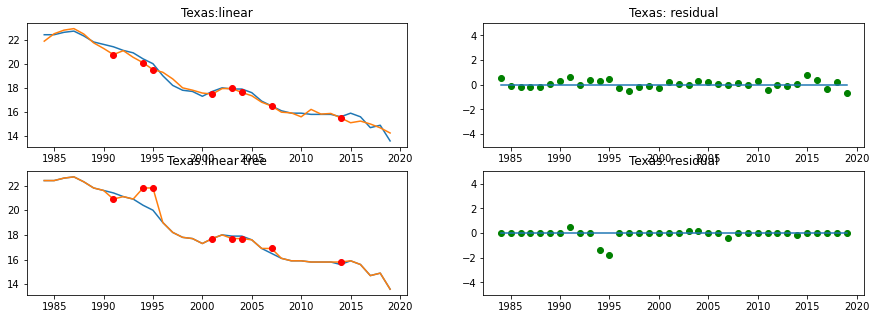

In [14]:
# Pick data for 1 state
state_to_model = 'Texas'
model_state_df = model_df.loc[model_df['state']==state_to_model].dropna().set_index('year')
model_state_df.drop(columns=['state'], inplace=True)
model_state_df

# Define X and y variables
X = model_state_df.drop(["poverty_rate"], axis=1)  #.values.reshape(-1, 1)
y = model_state_df["poverty_rate"]
print(f'X shape: {X.shape}')
X.head()

#  CHECK IF THIS IS NEEDED ********************************************
# std = preprocessing.StandardScaler()
# X is a matrix
#std.fit(X)
#X_std = std.transform(X)

# Create a model with scikit-learn
model = LinearRegression()
model_tree = DecisionTreeRegressor()
# Test the model by using train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

# Fit the data into the model
model.fit(X_train, y_train)
model_tree.fit(X_train, y_train)

# We use the predict() on the model to predict the output
# The model creates predicted y values based on X values
y_pred = model.predict(X)
y_tree_pred = model_tree.predict(X)

## Use this to plot training data
y_pred_test = model.predict(X_test)
y_tree_pred_test = model_tree.predict(X_test)

print('---- SHAPES ---')
print(y_pred.shape)
print(X.shape)
print('----- EVALUATION LINEAR MODEL ------')
print(f'Mean absolute error: {mean_absolute_error(y,y_pred)}')
print(f'Mean square error: {mean_squared_error(y,y_pred)}')
print(f'r2 score: {r2_score(y,y_pred)}')
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')
print('----- EVALUATION TREE LINEAR MODEL ------')
print(f'Mean absolute error: {mean_absolute_error(y,y_tree_pred)}')
print(f'Mean square error: {mean_squared_error(y,y_tree_pred)}')
print(f'r2 score: {r2_score(y,y_tree_pred)}')
#print(f'Score: {model_tree.score}')
print(f'Feature Importance: {model_tree.feature_importances_}')

model_state_df['predicted_poverty'] = y_pred
model_state_df['predicted_poverty_tree'] = y_tree_pred
model_state_df.head()

# Plot the results. The best fit line is red.
#model_state_df.plot(y=['poverty_rate','predicted_poverty'], use_index=True, title=state_to_model )
fig, ax = plt.subplots(2,2, figsize=(15,5))
ax[0][0].plot(model_state_df.index.values, model_state_df['poverty_rate'],
         model_state_df.index.values,model_state_df['predicted_poverty'])
ax[0][0].plot(X_test.index, y_pred_test, color='r', marker='o', lw=0)
ax[0][0].set_title(f'{state_to_model}:linear')

ax[0][1].plot(model_state_df.index.values, (model_state_df['poverty_rate']-model_state_df['predicted_poverty']),
          color='g', marker='o', lw=0)
ax[0][1].set_title(f'{state_to_model}: residual')
ax[0][1].set_ylim([-5,5])
ax[0][1].plot([model_state_df.index.values.min(),model_state_df.index.values.max()],[0,0])
ax[1][0].plot(model_state_df.index.values, model_state_df['poverty_rate'],
         model_state_df.index.values,model_state_df['predicted_poverty_tree'])
ax[1][0].plot(X_test.index, y_tree_pred_test, color='r', marker='o', lw=0)
ax[1][0].set_title(f'{state_to_model}:linear tree')
ax[1][1].plot(model_state_df.index.values, (model_state_df['poverty_rate']-model_state_df['predicted_poverty_tree']),
          color='g', marker='o', lw=0)
ax[1][1].set_title(f'{state_to_model}: residual')
ax[1][1].set_ylim([-5,5])
ax[1][1].plot([model_state_df.index.values.min(),model_state_df.index.values.max()],[0,0])
plt.show()

In [15]:
X.columns

Index(['crime_rate', 'unemployment_rate', 'divorce_rate_per_1000_people',
       'homeownership_rate', 'minimum_wage_effective', 'cpi_average',
       'inflation_rate', 'avg_wage_index', 'education_per_capita',
       'welfare_per_capita'],
      dtype='object')

## Create Function

In [16]:
# create, train and test a model on dataframe df, filtering on state using the model_type

def run_models(df, use_training_test_split=False):

####    Set up split used for training/test size
    training_size = 0.9
##############################################################
    result_df = pd.DataFrame()
    rows_plots = len(df.state.unique())
    fig, ax = plt.subplots(rows_plots, 2 , figsize=(20, 5*rows_plots))
    
    for row, state in enumerate(df.state.unique()):
        m_df = df.loc[df['state']==state].dropna().set_index('year')
        m_df.drop(columns=['state'], inplace=True)

    # Define X and y variables
        X = m_df.drop(["poverty_rate"], axis=1)
        y = m_df["poverty_rate"]

    # Create a model with scikit-learn
        model = LinearRegression()
        model_tree = DecisionTreeRegressor()
        
    # Test the model by using train and test dataset
    # Fit the data into the model
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=training_size)
        
        if use_training_test_split:
            model.fit(X_train, y_train)
            model_tree.fit(X_train, y_train)
        else:
            model.fit(X,y)
            model_tree.fit(X,y)
            
    # We use the predict() on the model to predict the output
    # The model creates predicted y values based on X values
        y_pred = model.predict(X)
        y_tree_pred = model_tree.predict(X)
        m_df['predicted_poverty_linear'] = y_pred
        m_df['predicted_poverty_tree'] = y_tree_pred
    
    # Use y_pred_test to plot testing points
        if use_training_test_split:
            y_pred_test = model.predict(X_test)
            r2s = r2_score(y_test,y_pred_test)
            y_tree_pred_test = model_tree.predict(X_test)
            r2s_tree = r2_score(y_test,y_tree_pred_test)
        else:
            r2s = r2_score(y, y_pred)
            r2s_tree = r2_score(y, y_tree_pred)
 
    # Plot state results
        ax[row][0].plot(m_df.index.values, m_df['poverty_rate'],
             m_df.index.values, m_df['predicted_poverty_linear'])
        ax[row][0].plot(m_df.index.values, m_df['poverty_rate'],
             m_df.index.values, m_df['predicted_poverty_tree'])
        ax[row][0].set_title(f'{state}: r2 score: linear:{r2s:.3f}|tree:{r2s_tree:.3f}')
        ax[row][1].plot(m_df.index.values,(m_df['poverty_rate']-m_df['predicted_poverty_linear']),color='r', marker='o', lw=0)
        ax[row][1].plot(m_df.index.values,(m_df['poverty_rate']-m_df['predicted_poverty_tree']),color='g', marker='o', lw=0)
        ax[row][1].set_title(f'{state}: residual')
        ax[row][1].set_ylim([-5,5])
        ax[row][1].plot([m_df.index.values.min(),m_df.index.values.max()],[0,0])
        ax[row][1].plot([m_df.index.values.min(),m_df.index.values.max()],[1,1], color='r')
        ax[row][1].plot([m_df.index.values.min(),m_df.index.values.max()],[-1,-1], color='r')
        if use_training_test_split:
            ax[row][0].plot(X_test.index, y_pred_test, color='r', marker='o', lw=0)
            ax[row][0].plot(X_test.index, y_tree_pred_test, color='g', marker='o', lw=0)
            

            
        if use_training_test_split:
            result = { 'State': state,
                    'Best Model': ("linear" if r2s>r2s_tree else "tree"),
                    'Mean absolute error linear': mean_absolute_error(y_test,y_pred_test),
                    'Mean square error linear': mean_squared_error(y_test,y_pred_test),
                    'r2 score linear': r2s,
                    'Mean absolute error tree': mean_absolute_error(y_test,y_tree_pred_test),
                    'Mean square error tree': mean_squared_error(y_test,y_tree_pred_test),
                    'r2 score tree': r2s_tree
                  }
        else:
            result = { 'State': state,
                    'Best Model': ("linear" if r2s>r2s_tree else "tree"),
                    'Mean absolute error linear': mean_absolute_error(y,y_pred),
                    'MSE linear': mean_squared_error(y,y_pred),
                    'r2 score linear': r2s,
                    'Mean absolute error tree': mean_absolute_error(y_test,y_tree_pred),
                    'MSE tree': mean_squared_error(y_test,y_tree_pred),
                    'r2 score tree': r2s_tree
                    #'Coefficients': model.coef_,
                    #'Intercept': model.intercept_
                  }
        result_df = result_df.append(result, ignore_index=True)
    plt.show()
    return result_df
    

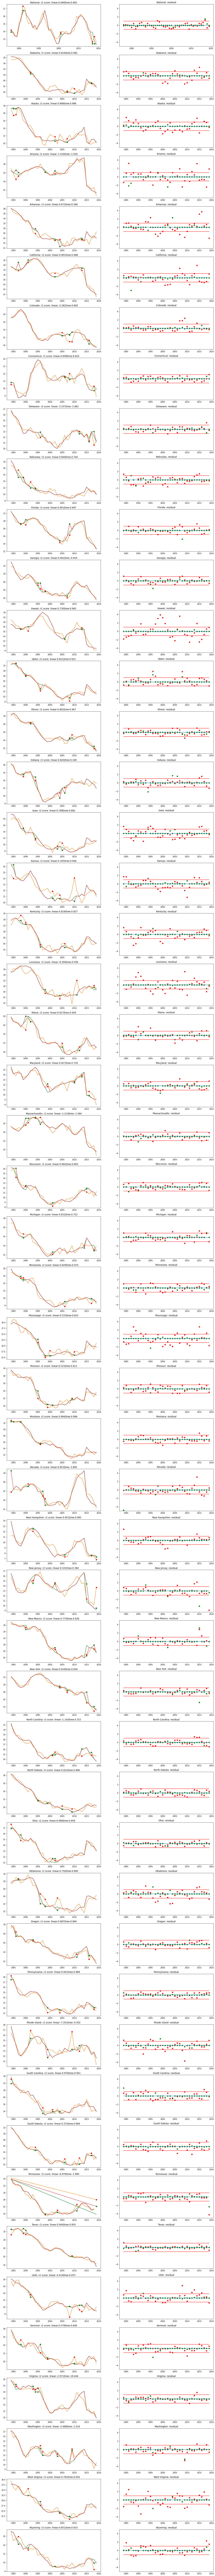

In [24]:
result_df = pd.DataFrame()

result = run_models(model_df, True)
result_df = result_df.append(result, ignore_index=True)


## States by their r2 score

In [25]:
result_df.sort_values(by=['State'], ascending=False).reset_index(drop=True)

,Best Model,Mean absolute error linear,Mean absolute error tree,Mean square error linear,Mean square error tree,State,r2 score linear,r2 score tree
0,tree,1.167641,0.5500,1.958645,0.375000,Wyoming,0.651293,0.933237
1,tree,0.716273,0.6500,0.557394,0.550000,Wisconsin,0.891808,0.893243
2,tree,1.259780,0.8250,3.063729,1.242500,West Virginia,0.791680,0.915516
3,tree,1.276948,0.9750,2.348834,1.607500,Washington,-2.688062,-1.524043
4,linear,0.193441,0.5500,0.067012,0.345000,Virginia,-2.971076,-19.444444
5,tree,0.833020,0.7750,1.277050,1.197500,Vermont,0.579485,0.605680
6,tree,1.649133,0.3500,3.572190,0.315000,Utah,-0.413679,0.875340
7,tree,0.495715,0.5000,0.387568,0.345000,Texas,0.943927,0.950086
8,tree,1.483070,0.8000,4.839854,1.450000,Tennessee,-8.979080,-1.989691
9,tree,1.382107,0.2750,2.070929,0.117500,South Dakota,0.371851,0.964360


In [26]:
result_df['Best Model'].value_counts()

tree      36
linear    15
Name: Best Model, dtype: int64

## Set r2 threshold create a list of states over the threshold. For models under the threshold, add the state to the list of model with the highest r2 score.

In [27]:
r2_threshold = 0.75

In [28]:
state_linear_models = result_df.loc[(result_df['Best Model']=="linear")].State
state_tree_models = result_df.loc[~(result_df['State'].isin(state_linear_models))].State
print(f'Number of linear models: {len(state_linear_models)}')
print(state_linear_models)
print(f'Number of tree models: {len(state_tree_models)}')
print(state_tree_models)

Number of linear models: 15
3            Arizona
4           Arkansas
5         California
10           Florida
11           Georgia
15           Indiana
21          Maryland
22     Massachusetts
24          Michigan
29            Nevada
32        New Mexico
33          New York
36              Ohio
41    South Carolina
47          Virginia
Name: State, dtype: object
Number of tree models: 36
0           National
1            Alabama
2             Alaska
6           Colorado
7        Connecticut
8           Delaware
9           Nebraska
12            Hawaii
13             Idaho
14          Illinois
16              Iowa
17            Kansas
18          Kentucky
19         Louisiana
20             Maine
23         Wisconsin
25         Minnesota
26       Mississippi
27          Missouri
28           Montana
30     New Hampshire
31        New Jersey
34    North Carolina
35      North Dakota
37          Oklahoma
38            Oregon
39      Pennsylvania
40      Rhode Island
42      South Da

## Generate models for all states and save to specific folder based on the lists above

In [29]:
model_summary_df = pd.DataFrame()
for state in state_linear_models:
    record_data = {'State': state,
              'Model': "LinearRegression",
              "R2 Score": result_df.loc[result_df['State']==state, "r2 score linear"].max()
             }
    model_summary_df = model_summary_df.append(record_data, ignore_index=True)
for state in state_tree_models:
    record_data = {'State': state,
              'Model': "DecissionTreeRegressor",
              "R2 Score": result_df.loc[result_df['State']==state, "r2 score tree"].max()
             }
    model_summary_df = model_summary_df.append(record_data, ignore_index=True)
    
model_summary_df = model_summary_df[['State','Model','R2 Score']]
model_summary_df.to_csv("Model_summary.csv", index=None)
model_summary_df

,State,Model,R2 Score
0,Arizona,LinearRegression,-1.519749
1,Arkansas,LinearRegression,0.671610
2,California,LinearRegression,0.800700
3,Florida,LinearRegression,0.890699
4,Georgia,LinearRegression,0.480512
5,Indiana,LinearRegression,0.823833
6,Maryland,LinearRegression,0.816584
7,Massachusetts,LinearRegression,-1.213782
8,Michigan,LinearRegression,0.831647
9,Nevada,LinearRegression,0.852687


In [30]:
model_list_df = pd.DataFrame()

filepath = "Best_Models/"

# Create, train and save a model for each state in states_to_keep
# keep a summary dataframe

for state in model_summary_df['State'].unique():
    model_type = model_summary_df.loc[model_summary_df['State']==state, "Model"].index[0]
    m_df = model_df.loc[model_df['state']==state].dropna().set_index('year')
    m_df.drop(columns=['state'], inplace=True)
    X = m_df.drop(columns=['poverty_rate'])
    y = m_df['poverty_rate']
    
    if model_type=="LinearRegression":
        model = LinearRegression()
    else:
        model = DecisionTreeRegressor()
        
    model.fit(X,y)
    
    model_filename = state + '.sav'
    path_filename = filepath + model_filename
    
    # save model
    pickle.dump(model, open(path_filename, 'wb'))
       
